In [1]:
import numpy as np
from math import sqrt
import copy
import scipy.linalg
import matplotlib.pyplot as plt
import random
import seaborn as sns; sns.set()

In [2]:
class gelasticnetSover(object):

    def gmulup_solve(self,Amat, lvec, bvec,dvec, v0, err_tol = 1e-8, text='Off', text_fr=200):
        A_plus = copy.deepcopy(Amat)
        A_plus[A_plus<0]=0

        A_minus = copy.deepcopy(Amat)
        A_minus[A_minus>0]=0
        A_minus = abs(A_minus)

        v = np.array([1.0 for x in range(len(bvec))])
        
        old_v = np.array([0 for x in range(len(bvec))])
        v0=v0.astype(float)
        v0[np.where(v0==0)]=0.00000001
        updateFactor0 = v0/v
        updateFactor = np.array([1.0 for x in range(len(bvec))])
        count=0
        while(((old_v-v)**2).sum()>err_tol):
            dFa = np.array(A_plus.dot(v))
            dFb = copy.deepcopy(bvec)
            dFc = np.array(A_minus.dot(v))
            for i in range(len(bvec)):
                if dFa[i]==0:
                    dFa[i]=0.00000001
                if dFa[i]*updateFactor0[i]+(dFb[i]-dvec[i])-dFc[i]/updateFactor0[i]>0:
                    updateFactor[i] = float((-(dFb[i]-dvec[i])+sqrt((dFb[i]-dvec[i])**2+4*dFa[i]*dFc[i]))/(2*dFa[i]))
                elif dFa[i]*updateFactor0[i]+(dFb[i]+dvec[i])-dFc[i]/updateFactor0[i]<0:
                    updateFactor[i] = float((-(dFb[i]+dvec[i])+sqrt((dFb[i]+dvec[i])**2+4*dFa[i]*dFc[i]))/(2*dFa[i]))
                else:
                    updateFactor[i] = updateFactor0[i]
            if np.count_nonzero(~np.isnan(updateFactor)) ==len(bvec):
                old_v = copy.deepcopy(v)
                v = np.minimum(lvec, updateFactor * v)
            else:
                break
            if (count % text_fr == 0) & (text == 'On'):
                print(((old_v-v)**2).sum())
            count+=1
            updateFactor0 = v0/v
        return v
   




    
    def solve(self, Xmat, Yvec, lam_1, lam_2, lowbo, upbo, wvec, Sigma, err_tol = 1e-8, text='Off', text_fr=200):  
        """Xmat, Yvec, lowbo, upbo,  wvec, Sigma,: numpy array;
           lam_1, lam_2: float; """
        p = Xmat.shape[1]
        Amat = Xmat.transpose().dot(Xmat) + lam_2*Sigma
        bvec = 2*Amat.dot(lowbo)-2*Xmat.transpose().dot(Yvec)
        Amat = 2*Amat
        dvec = lam_1*wvec
        v0 = np.maximum(0,-lowbo)
        lvec = upbo-lowbo
        v=self.gmulup_solve(Amat, lvec, bvec,dvec, v0, err_tol, text, text_fr)
        
        
        beta = v+lowbo
        return beta   #, plo
    
# To solve prob: Yvec=Xmat*beta

# Example of input
# Xmat = np.random.randn(N,K)
# Yvec = np.random.randn(N)
# lam_1 = 0.0034 
# lam_2 = 0
# Sigma = np.diag([1]*K)
# wvec = np.ones(K)
# lowbo = -1*np.ones(N)
# upbo = 1*np.ones(N)

In [11]:
## generating signal

# signal length
N=400
# number of spikes in the signal
T=16
# number of observations to make
K=102
random.seed(0)
# random +/- 1 signal
x=np.zeros((N,1))
q=np.random.permutation(N)
x[q[0:T]]=np.sign(np.random.randn(T,1))

# measurement matrix
A = np.random.randn(K,N)
A = scipy.linalg.orth(A.transpose()).transpose()

# observations
y = np.reshape(A.dot(x),(A.dot(x).shape[0],))

## solve the en problem
s = gelasticnetSover()

In [12]:
A.shape

(102, 400)

In [13]:
## parameters setting
lam_1 = 0.0034 #0.01*np.linalg.norm((A.transpose()).dot(y),np.inf) #0.0034
lam_2 = 0
p = A.shape[1]
# Pmat = np.random.randn(p,p)
# Pmat=(Pmat + Pmat.T)/2
Pmat=np.ones((p,p))
# dvec = abs(np.random.random(p))
dvec = np.ones(p)
lowbo=-1*np.ones(N)
upbo=1*np.ones(N)
coeffs=s.solve(A,y,lam_1,lam_2,lowbo,upbo,dvec, Pmat,err_tol=1e-8, text_fr=1000)

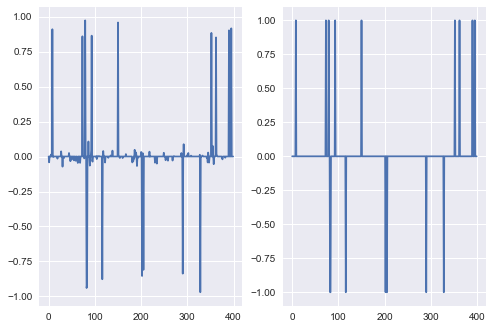

mse:  0.0007605211728017507


In [14]:
plt.subplot(1, 2, 1)
plt.plot(coeffs)
plt.subplot(1, 2, 2)
plt.plot(x)
plt.show()
print('mse: ',np.sum((coeffs.reshape(x.shape)-x)**2)/len(x))

### Try SnP 500

In [44]:
import pandas as pd

In [69]:
def tracking_error(r_a, r_b, period='d'):
    if period=='y':
        return np.sqrt(252)*np.std(r_a - r_b)
    elif period=='m':
        return np.sqrt(30)*np.std(r_a - r_b)
    else:
        return np.std(r_a - r_b)

In [50]:
mydateparser = lambda x: pd.datetime.strptime(x, "%m/%d/%y")
sp500_all = pd.read_csv('sandp500/sp500_pct.csv', index_col='Date', parse_dates=['Date.1'], date_parser = mydateparser)

sp500_all.index = sp500_all['Date.1']

In [51]:
constituents_names = sp500_all.columns.tolist()
constituents_names = [x for x in constituents_names if x not in ['Date', 'Date.1', 'SP500']]
constituents = sp500_all[constituents_names]
sp500 = sp500_all['SP500']
# constituents['Date'] = pd.to_datetime(constituents.index)
# sp500['Date'] = pd.to_datetime(sp500.index)

In [53]:
from datetime import date
print(min(sp500_all['Date.1']))
print(max(sp500_all['Date.1']))

training_starts = ['2014-04-15', '2014-10-15', '2015-04-15', '2015-10-15',
                  '2016-04-15', '2016-10-15', '2017-04-15', '2017-10-15']
training_ends =['2014-09-15', '2015-03-15', '2015-09-15', '2016-03-15',
               '2016-09-15', '2017-03-15', '2017-09-15', '2018-03-15']
testing_starts = training_ends
testing_ends =['2014-10-15', '2015-04-15', '2015-10-15', '2016-04-15',
              '2016-10-15', '2017-04-15', '2017-10-15', '2018-04-15']

2014-04-15 00:00:00
2018-03-27 00:00:00


In [72]:
sp500_all

,XRX,GS,MTB,V,CTAS,APH,BBT,RHI,HD,PEP,...,CERN,SJM,WY,WFC,QCOM,COF,COG,F,SP500,Date.1
Date.1,,,,,,,,,,,,,,,,,,,,,
2014-04-15,-0.003524,0.001163,-0.003806,0.015124,0.000533,0.001535,0.007981,0.002993,-0.001053,0.004907,...,0.020806,-0.003250,-0.004661,0.013926,0.004423,0.006211,0.006410,0.008917,0.006757,2014-04-15
2014-04-16,0.016799,0.014846,0.010383,0.026023,0.011005,0.022110,0.004853,0.032082,0.009092,0.009647,...,0.000185,0.018406,0.005043,0.006355,0.008680,0.008588,0.032757,0.014520,0.010488,2014-04-16
2014-04-17,-0.006087,0.001399,-0.000822,-0.006735,0.011763,0.007925,-0.035841,0.016386,0.006660,0.009201,...,0.000371,-0.001343,-0.001075,-0.003259,0.014218,-0.003592,0.025551,-0.004356,0.001364,2014-04-17
2014-04-21,0.003500,0.002287,-0.003044,0.005674,-0.004164,0.002550,-0.003427,0.000948,0.011286,0.004208,...,0.002037,0.000310,0.011841,0.003883,-0.004796,0.002136,0.005727,-0.001250,0.003775,2014-04-21
2014-04-22,0.010462,0.016857,0.006437,0.004017,0.007144,0.006889,0.008201,0.018238,0.021934,-0.008963,...,-0.007392,0.002068,0.008865,0.002239,-0.003954,0.000799,0.015091,0.007509,0.004092,2014-04-22
2014-04-23,0.031924,-0.000062,0.008528,-0.005477,0.000692,0.005473,-0.001574,0.010468,-0.014435,0.003171,...,-0.015267,-0.005262,0.005272,0.007313,0.001241,-0.002530,0.013745,0.008075,-0.002213,2014-04-23
2014-04-24,0.002508,0.002493,-0.000650,0.002778,0.003976,0.008270,-0.006307,0.014963,0.015920,0.001288,...,-0.011155,0.005912,0.004895,-0.005445,-0.035188,-0.002403,0.050636,0.005545,0.001717,2014-04-24
2014-04-25,-0.020851,-0.016226,-0.005451,-0.050000,-0.008955,-0.016715,-0.012695,-0.022000,-0.004889,-0.003157,...,-0.053346,-0.010001,0.027140,-0.005474,-0.003339,-0.018732,0.005531,-0.033088,-0.008096,2014-04-25
2014-04-28,0.022147,-0.010743,-0.002863,0.012517,0.006082,0.000211,-0.004554,0.011364,0.009952,0.018416,...,-0.001616,0.014997,0.009824,-0.002243,0.005669,-0.005318,0.017287,0.012041,0.003236,2014-04-28


2014-04-15 2014-09-15 2014-09-15 2014-10-15


/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


2014-10-15 2015-03-15 2015-03-15 2015-04-15
2015-04-15 2015-09-15 2015-09-15 2015-10-15
2015-10-15 2016-03-15 2016-03-15 2016-04-15
2016-04-15 2016-09-15 2016-09-15 2016-10-15


/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


2016-10-15 2017-03-15 2017-03-15 2017-04-15


/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


2017-04-15 2017-09-15 2017-09-15 2017-10-15


/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017-10-15 2018-03-15 2018-03-15 2018-04-15


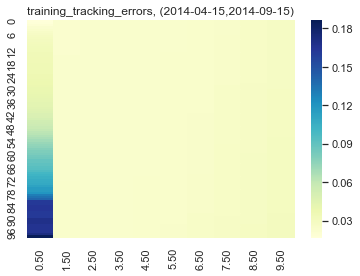

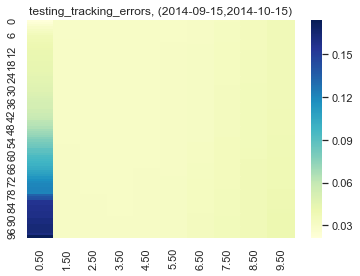

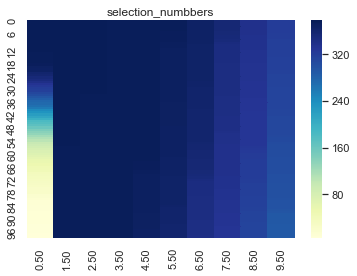

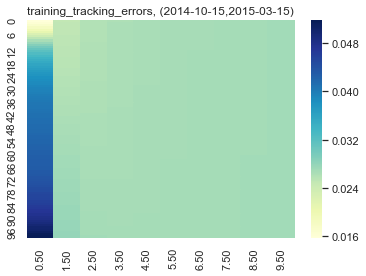

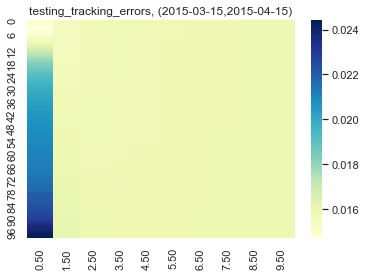

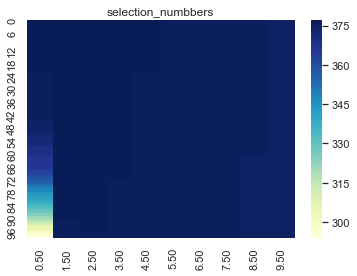

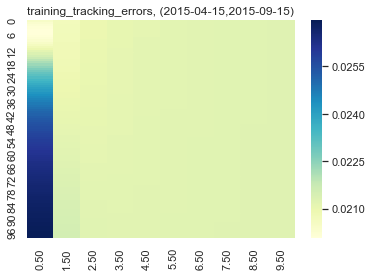

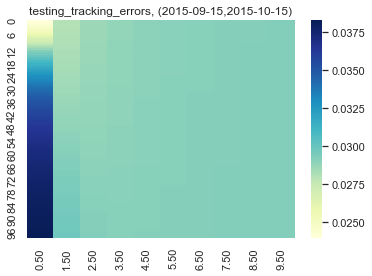

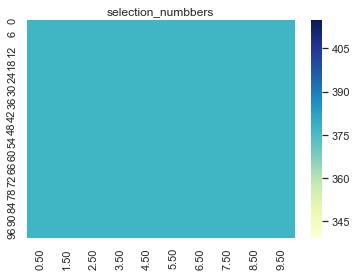

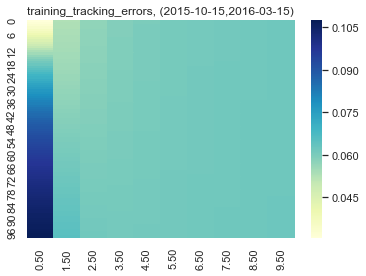

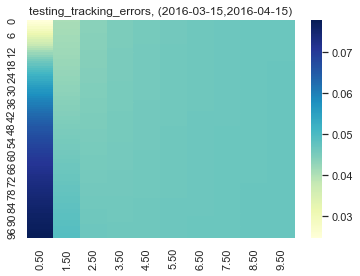

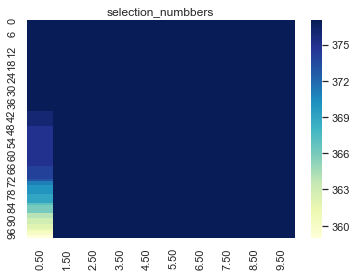

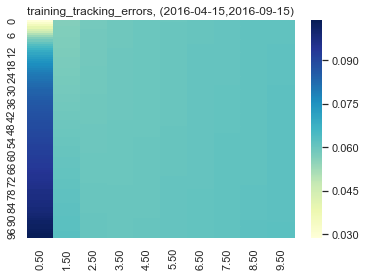

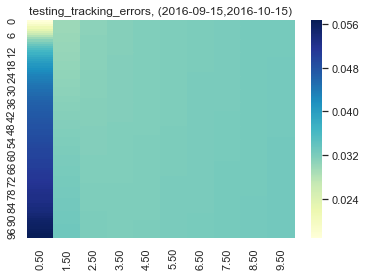

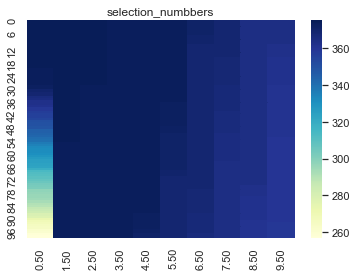

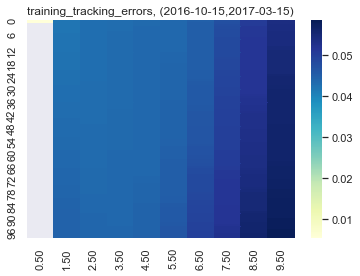

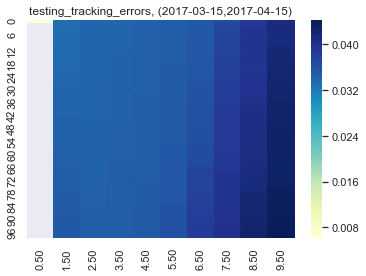

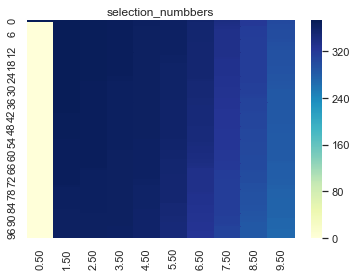

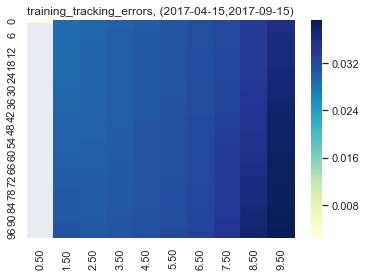

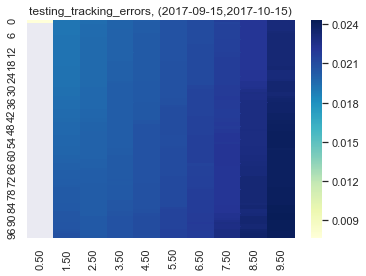

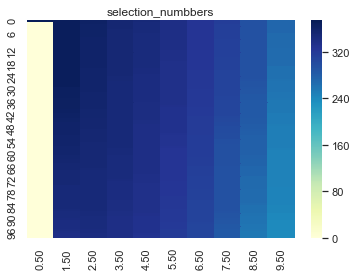

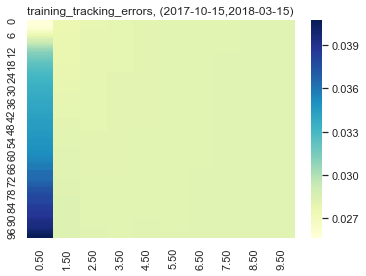

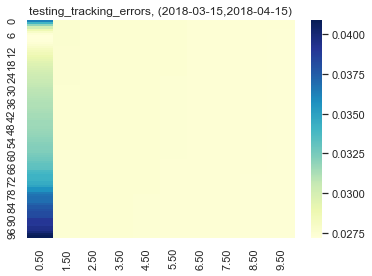

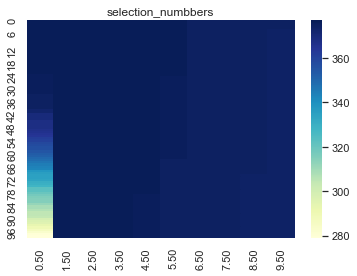

In [71]:
from itertools import product
cutting_threshold = 1e-5


for training_start, training_end, testing_start, testing_end in zip(training_starts, training_ends, testing_starts, testing_ends):
    
    print(training_start, training_end, testing_start, testing_end)
    
    mask = (constituents.index>=training_start ) & (constituents.index<=training_end ) 
    training_X = constituents.loc[mask]
    training_y = sp500.loc[mask]
    mask = (constituents.index>=testing_start ) & (constituents.index<=testing_end ) 
    testing_X = constituents.loc[mask]
    testing_y = sp500.loc[mask]

    lam_1s = [1*i for i in range(100)]
    
    lam_2s = [0.05*i for i in range(10)]
    
    selections = []
    
    training_tracking_errors = np.empty((len(lam_1s), len(lam_2s)))
    
    testing_tracking_errors = np.empty((len(lam_1s), len(lam_2s)))
    
    selection_numbbers = np.empty((len(lam_1s), len(lam_2s)))
    
    tot_it = len(lam_1s)*len(lam_2s)
    
    counter = 0
    # for lam_1, lam_2 in product(lam_1s, lam_2s):
    for i, lam_1 in enumerate(lam_1s):
        for j, lam_2 in enumerate(lam_2s):
            p = training_X.shape[1]
            # Pmat = np.random.randn(p,p)
            # Pmat=(Pmat + Pmat.T)/2
            Pmat=np.ones((p,p))
            # dvec = abs(np.random.random(p))
            dvec = np.ones(p)
            lowbo=0*np.ones(p)
            upbo=1*np.ones(p)
            coeffs=s.solve(training_X,training_y,lam_1,lam_2,lowbo,upbo,dvec, Pmat,err_tol=1e-8, text_fr=10, text='Off')
            selection = np.array([x if x >cutting_threshold else 0 for x in coeffs])
            selection = selection/sum(selection)
            selection_ind = np.where(selection>0)[0]
            selections.append(selection)
            training_fund_index = training_X @ (selection)
            training_tracking_errors[i,j] = tracking_error(training_y, training_fund_index, period='y')
            testing_fund_index = testing_X @ (selection)
            testing_tracking_errors[i,j] = tracking_error(testing_y, testing_fund_index, period='y')
            selection_numbbers[i,j] = len(selection_ind)
#             print('processing lam_1={}, and lam_2={} ({:.3f}% out of {}): number of selection: {}'.format(lam_1, lam_2, 100*counter/tot_it, tot_it, len(selection_ind)))
            counter += 1
    
    data = pd.DataFrame(training_tracking_errors)
    data.columns = lam_2s
    data.index = lam_1s
    plt.figure()
    ax = sns.heatmap(data,cmap="YlGnBu")
    ax.set_title('training_tracking_errors, ({},{})'.format(training_start, training_end))
    ax.set_xticklabels(['{:,.2f}'.format(x) for x in ax.get_xticks()])
#     ax.show()
    data = pd.DataFrame(testing_tracking_errors)
    data.columns = lam_2s
    data.index = lam_1s
    plt.figure()
    ax = sns.heatmap(data,cmap="YlGnBu")
    ax.set_title('testing_tracking_errors, ({},{})'.format(testing_start, testing_end))
    ax.set_xticklabels(['{:,.2f}'.format(x) for x in ax.get_xticks()])
#     ax.show()
    data = pd.DataFrame(selection_numbbers)
    data.columns = lam_2s
    data.index = lam_1s
    plt.figure()
    ax = sns.heatmap(data,cmap="YlGnBu")
    ax.set_title('selection_numbbers')
    ax.set_xticklabels(['{:,.2f}'.format(x) for x in ax.get_xticks()])
#     ax.show()

In [8]:
N = 90
A = constituents.iloc[:N,:].values
y = sp500[:N].values
cutting_threshold = 1e-5
## solve the en problem
s = gelasticnetSover()

In [9]:
lam_1 = 55#0.01*np.linalg.norm((A.transpose()).dot(y),np.inf) 
lam_2 = 0
print('lambda_1:{}, lambda_2:{}'.format(lam_1, lam_2))
p = A.shape[1]
# Pmat = np.random.randn(p,p)
# Pmat=(Pmat + Pmat.T)/2
Pmat=np.ones((p,p))
# dvec = abs(np.random.random(p))
dvec = np.ones(p)
lowbo=0*np.ones(p)
upbo=1*np.ones(p)
coeffs=s.solve(A,y,lam_1,lam_2,lowbo,upbo,dvec, Pmat,err_tol=1e-8, text_fr=10, text='Off')
selection = np.array([x if x >cutting_threshold else 0 for x in coeffs])
selection = selection/sum(selection)
selection_ind = np.where(selection>0)[0]
print('number of selected stocks: {}'.format(len(selection_ind)))
A_ = A[:,selection_ind]
p_ = A_.shape[1]
Pmat_=np.ones((p_,p_))
# dvec = abs(np.random.random(p))
dvec_ = np.ones(p_)
lowbo_=0*np.ones(p_)
upbo_=1*np.ones(p_)
coeffs_=s.solve(A_,y,lam_1,lam_2,lowbo_,upbo_,dvec_, Pmat_,err_tol=1e-8, text_fr=10, text='Off')
coeffs_ = coeffs_/sum(coeffs_)
fund_index = A @ (selection)
fund_index_ = A_ @ (coeffs_)

print('sum coeffs:{}'.format(sum(coeffs)))

lambda_1:55, lambda_2:0
number of selected stocks: 89
sum coeffs:0.0029134196381272147


/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


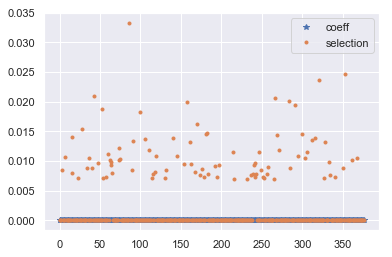

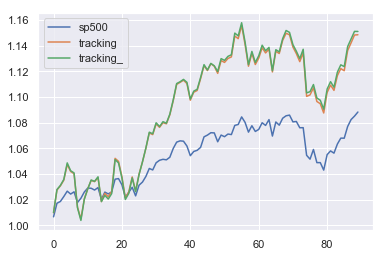

tracking error(monthly): 2.474%
tracking error_(yearly): 2.582%


In [10]:
plt.plot(coeffs, linewidth=0,marker="*")
plt.plot(selection.tolist(), linewidth=0,marker=".")
plt.legend(['coeff', 'selection'])
plt.show()

plt.plot(np.cumprod(1+y))
plt.plot(np.cumprod(1+fund_index))
plt.plot(np.cumprod(1+fund_index_))
plt.legend(['sp500', 'tracking', 'tracking_'])
plt.show()
print('tracking error(monthly): {:.3f}%'.format(np.sqrt(25)*100*tracking_error(y, fund_index)))
print('tracking error_(yearly): {:.3f}%'.format(np.sqrt(25)*100*tracking_error(y, fund_index_)))

In [11]:
from itertools import product

lam_1s = [1*i for i in range(200)]
lam_2s = [0.05*i for i in range(30)]
cutting_threshold = 1e-5
selections = []
tracking_errors = np.empty((len(lam_1s), len(lam_2s)))
selection_numbbers = np.empty((len(lam_1s), len(lam_2s)))
tot_it = len(lam_1s)*len(lam_2s)
counter = 1
i=0
j=0
# for lam_1, lam_2 in product(lam_1s, lam_2s):
for i, lam_1 in enumerate(lam_1s):
    for j, lam_2 in enumerate(lam_2s):
        p = A.shape[1]
        # Pmat = np.random.randn(p,p)
        # Pmat=(Pmat + Pmat.T)/2
        Pmat=np.ones((p,p))
        # dvec = abs(np.random.random(p))
        dvec = np.ones(p)
        lowbo=0*np.ones(p)
        upbo=1*np.ones(p)
        coeffs=s.solve(A,y,lam_1,lam_2,lowbo,upbo,dvec, Pmat,err_tol=1e-8, text_fr=10, text='Off')
        selection = np.array([x if x >cutting_threshold else 0 for x in coeffs])
        selection = selection/sum(selection)
        selection_ind = np.where(selection>0)[0]
        selections.append(selection)
        fund_index = A @ (selection)
        tracking_errors[i,j] = np.sqrt(252)*tracking_error(y, fund_index)
        selection_numbbers[i,j] = len(selection_ind)
        print('processing lam_1={}, and lam_2={} ({:.3f}% out of {}): number of selection: {}'.format(lam_1, lam_2, 100*counter/tot_it, tot_it, len(selection_ind)))
        counter += 1

/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


processing lam_1=0, and lam_2=0.0 (0.017% out of 6000): number of selection: 377
processing lam_1=0, and lam_2=0.05 (0.033% out of 6000): number of selection: 377
processing lam_1=0, and lam_2=0.1 (0.050% out of 6000): number of selection: 376
processing lam_1=0, and lam_2=0.15000000000000002 (0.067% out of 6000): number of selection: 375
processing lam_1=0, and lam_2=0.2 (0.083% out of 6000): number of selection: 372
processing lam_1=0, and lam_2=0.25 (0.100% out of 6000): number of selection: 366
processing lam_1=0, and lam_2=0.30000000000000004 (0.117% out of 6000): number of selection: 351
processing lam_1=0, and lam_2=0.35000000000000003 (0.133% out of 6000): number of selection: 337
processing lam_1=0, and lam_2=0.4 (0.150% out of 6000): number of selection: 324
processing lam_1=0, and lam_2=0.45 (0.167% out of 6000): number of selection: 307
processing lam_1=0, and lam_2=0.5 (0.183% out of 6000): number of selection: 277
processing lam_1=0, and lam_2=0.55 (0.200% out of 6000): n

/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/arbitraryElasticNet/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


processing lam_1=122, and lam_2=0.35000000000000003 (61.133% out of 6000): number of selection: 306
processing lam_1=122, and lam_2=0.4 (61.150% out of 6000): number of selection: 278
processing lam_1=122, and lam_2=0.45 (61.167% out of 6000): number of selection: 260
processing lam_1=122, and lam_2=0.5 (61.183% out of 6000): number of selection: 227
processing lam_1=122, and lam_2=0.55 (61.200% out of 6000): number of selection: 190
processing lam_1=122, and lam_2=0.6000000000000001 (61.217% out of 6000): number of selection: 157
processing lam_1=122, and lam_2=0.65 (61.233% out of 6000): number of selection: 128
processing lam_1=122, and lam_2=0.7000000000000001 (61.250% out of 6000): number of selection: 103
processing lam_1=122, and lam_2=0.75 (61.267% out of 6000): number of selection: 79
processing lam_1=122, and lam_2=0.8 (61.283% out of 6000): number of selection: 61
processing lam_1=122, and lam_2=0.8500000000000001 (61.300% out of 6000): number of selection: 53
processing lam

(200, 30)


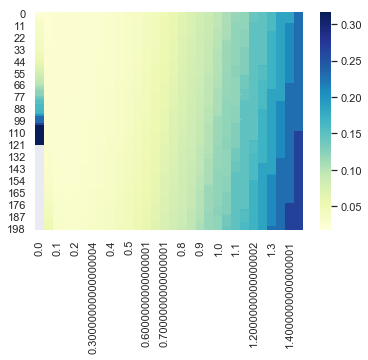

In [57]:
data = pd.DataFrame(tracking_errors)
print(data.shape)
data.columns = lam_2s
data.index = lam_1s
ax = sns.heatmap(data,cmap="YlGnBu")

(200, 30)


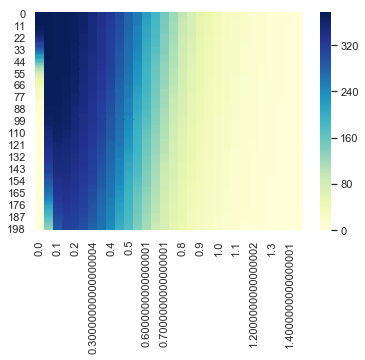

In [55]:
data = pd.DataFrame(selection_numbbers)
print(data.shape)
data.columns = lam_2s
data.index = lam_1s
ax = sns.heatmap(data,cmap="YlGnBu")